In [1]:
from generate_mdps import generate_datsets
from dataset import MDPDataset, AllNodeFeatures, InMemoryMDPDataset, TransitionsOnEdge
from experiment import Experiment
from MDP_helpers import calculate_gap, multiclass_recall_score

In [2]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import numpy as np

import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch_geometric.nn.models import GCN, GAT
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import random_split
from collections import defaultdict
from sklearn.metrics import recall_score

from time import time
from tqdm import tqdm

/home/james/virtual_envs/csiro_venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
torch.cuda.manual_seed(12345)
np.random.seed(12345)

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device='cpu'
print(device)

cuda


In [5]:
# hparam_file = "gat_hparams"
# experiment_name = "gcn_243_hparam_30"

# os.mkdir(f"Results/{experiment_name}") if not os.path.isdir(f"Results/{experiment_name}") else ...

In [16]:
N_datasets = 1

N_sites = 4
N_species = 20
K = 6

N_states = 3**N_sites
print(f"N_states: {N_states}")
generate_datsets(N_sites, N_species, K, N_datasets, remove_previous=True, folder="test")

N_states: 81
Deleting folder  datasets/test/raw
Generating 1 MDPs with 81 states and 4 actions 



100%|██████████| 1/1 [00:00<00:00, 28.83it/s]


In [8]:
# dataset = InMemoryMDPDataset(f"datasets/mdp_{N_states}_state", pre_transform=TransitionsOnEdge())
dataset = InMemoryMDPDataset(f"datasets/mdp_{N_states}_state", pre_transform=AllNodeFeatures())

In [9]:
torch.all(dataset[0].R == dataset[5].R)

tensor(False)

In [10]:
train_ratio = 0.8
test_ratio = 0.2

train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

h_param_size = int(train_ratio*train_size)
val_size = train_size - h_param_size

train_set, test_set = random_split(dataset, [train_size, test_size])
hparam_train_set, hparam_val_set = random_split(train_set, [h_param_size, val_size])

train_data = DataLoader(train_set, batch_size=1, shuffle=True)
test_data = DataLoader(test_set, batch_size=1, shuffle=True)
hparam_train_data = DataLoader(hparam_train_set, batch_size=1, shuffle=True)
hparam_val_data = DataLoader(hparam_val_set, batch_size=1, shuffle=True)

In [11]:
N_epochs = 500

def objective(trial):
    hidden_channels = trial.suggest_int("hidden_channels", 100, 250)
    num_layers = 1 # trial.suggest_int("num_layers", 1, 3)
    dropout = trial.suggest_float("dropout", 0, 0.05)
    lr = trial.suggest_float("lr", 1e-9, 10)
    weight_decay = trial.suggest_float("weight_decay", 1e-3, 0.05)
    gamma = trial.suggest_float("gamma", 0.95, 1)

    # hidden_channels = trial.suggest_int("hidden_channels", 150, 225)
    # num_layers = 1#trial.suggest_int("num_layers", 1, 3)
    # dropout = trial.suggest_float("dropout", 0, 0.05)
    # lr = trial.suggest_float("lr", 2, 8)
    # weight_decay = trial.suggest_float("weight_decay", 1e-3, 0.04)
    # gamma = trial.suggest_float("gamma", 0.95, 1)

    gcn_model = GCN(
        in_channels=dataset[0].x.shape[1], 
        out_channels=K, 
        hidden_channels=hidden_channels, 
        num_layers=num_layers, 
        dropout=dropout
    ).to(device)


    optimizer = torch.optim.Adam(gcn_model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_function = torch.nn.CrossEntropyLoss()
    lr_sheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma)

    gcn_model.train()
    for epoch in range(N_epochs):
        optimizer.zero_grad()     
        loss = 0
        for data in hparam_train_data:
            pred = gcn_model(
                x = data.x.to(device), 
                edge_index=data.edges.to(device), 
                # edge_attr=edge_features
            )
            loss += loss_function(pred, data.k_labels.to(device))
        loss.backward()
        optimizer.step()
        lr_sheduler.step()
    
    gcn_model.eval()
    errors = []
    recall = []
    for data in hparam_val_data:
        out = gcn_model(
                x = data.x.to(device), 
                edge_index=data.edges.to(device), 
                # edge_attr=edge_features
            )
        pred = F.softmax(out, dim=1).argmax(axis=1)#.to('cpu')

        _, error = calculate_gap(data.P, data.R, data.V, pred, K, device=device)
        errors.append(error.to('cpu'))
        recall.append(
            recall_score(data.k_labels.to('cpu'), pred.to('cpu'), average="macro")
        )
    
    return np.mean(recall) - np.mean(errors) # Minimise errors while maximising recall score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

best_params = study.best_params

print(study.best_value)
print(best_params)

[I 2023-11-03 19:33:45,401] A new study created in memory with name: no-name-86ba4b5d-2110-44b3-ba7a-748797dc410f
/home/james/Repo/MDP-State-Abstraction-CSIRO/Approach_new/gcn_model_multi/MDP_helpers.py:32: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3614.)
  Q[:, a] = R[:, a].T + gamma*T[a, :, :]@V
[I 2023-11-03 19:34:11,654] Trial 0 finished with value: -0.4463647044212118 and parameters: {'hidden_channels': 210, 'dropout': 0.048952866860454754, 'lr': 7.855390996259526, 'weight_decay': 0.04666024331573033, 'gamma': 0.9989933913233132}. Best is trial 0 with value: -0.4463647044212118.
[I 2023-11-03 19:34:59,111] Trial 1 finished with value: 0.43698494293769974 and parameters: {'h

0.6829568594767583
{'hidden_channels': 183, 'dropout': 0.016475365618156972, 'lr': 6.784415567678918, 'weight_decay': 0.0055837994627908095, 'gamma': 0.9634758573718306}


In [12]:
# trials = [i for i in map(lambda x: dict([("loss", x.values[0]), ("recall", x.values[1]),*(x.params).items()]), study.get_trials())]
# trials = pd.DataFrame(trials)
# trials = trials.sort_values(by='recall', ascending=False)

trials = [i for i in map(lambda x: dict([("score", x.values[0]),*(x.params).items()]), study.get_trials())]
trials = pd.DataFrame(trials)
trials = trials.sort_values(by='score', ascending=False)

experiment = Experiment(savefile=f"Results/{experiment_name}/hparams")
for i in trials.index:
    trials.loc[i].to_dict()
    experiment.save(trials.loc[i].to_dict())

pd.DataFrame(experiment.load()).sort_values(by="score", ascending=False).head()

,score,hidden_channels,dropout,lr,weight_decay,gamma
0,0.682957,183.0,0.016475,6.784416,0.005584,0.963476
1,0.677413,186.0,0.000032,4.675700,0.006103,0.961538
2,0.677259,177.0,0.000678,6.437710,0.005943,0.961330
3,0.673314,207.0,0.000293,4.051814,0.006406,0.963028
4,0.668282,135.0,0.015596,4.579810,0.008718,0.968010
5,0.653896,154.0,0.017005,2.420964,0.008629,0.969438
6,0.644393,191.0,0.004314,3.702617,0.009426,0.964844
7,0.631664,100.0,0.005925,6.029797,0.011882,0.970370
8,0.614291,138.0,0.011743,4.510381,0.006087,0.965183
9,0.609776,167.0,0.008394,3.539557,0.012664,0.968763


In [26]:
N_epochs = 300
all_results = defaultdict(lambda : defaultdict(list))

for trial_num in range(3):
    trial_name = f"trial_{trial_num}"
    # torch.cuda.manual_seed(12345)

    hidden_channels = int(best_params['hidden_channels'])
    num_layers = 1#int(best_params['num_layers'])
    dropout = best_params['dropout']
    lr = best_params['lr']
    weight_decay = best_params['weight_decay']
    gamma = best_params['gamma']
    # weight_spread = best_params["weight_spread"]

    model = GCN(
        in_channels=dataset[0].x.shape[1], 
        out_channels=K, 
        hidden_channels=hidden_channels, 
        num_layers=num_layers, 
        dropout=dropout
    ).to(device)


    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    # loss_function = torch.nn.CrossEntropyLoss()
    lr_sheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)

    epochs = tqdm(range(N_epochs))
    for epoch in epochs:
        model.train()
        optimizer.zero_grad()     

        loss = 0
        for data in train_data:
            pred = model(
                x = data.x.to(device), 
                edge_index=data.edges.to(device),
                # edge_attr = data.edge_features.to(device)
            )
            loss += F.cross_entropy(pred, data.k_labels.to(device))

        loss /= len(train_data) 
        loss.backward()
        optimizer.step()
        lr_sheduler.step()

        all_results[trial_name]['training_loss'].append(loss.to('cpu').detach().float())


        model.eval()
        test_loss = 0
        avg_gap = 0
        avg_error = 0
        avg_recall = 0
        for data in test_data:
            out = model(
                x = data.x.to(device), 
                edge_index=data.edges.to(device),
                # edge_attr = data.edge_features.to(device)
            )
            pred_k = F.softmax(pred, dim=1).argmax(axis=1)
            test_loss += F.cross_entropy(pred, data.k_labels.to(device))#, weight=weights(data.k_labels.to(device), weight_spread))
            gap, error = calculate_gap(data.P, data.R, data.V, pred_k, K, device='cpu')
            avg_gap += gap
            avg_error += error
            avg_recall += recall_score(data.k_labels, pred_k.to('cpu'), average="macro")


        test_loss /= len(test_data)
        avg_gap /= len(test_data)
        avg_error /= len(test_data)
        avg_recall /= len(test_data)

        all_results[trial_name]['test_loss'].append(test_loss.to('cpu').detach().float())
        all_results[trial_name]['test_gap'].append(avg_gap)
        all_results[trial_name]['test_error'].append(avg_error)
        all_results[trial_name]['test_recall'].append(avg_recall)

        epochs.set_description(f"Trial {trial_num}, Epoch {epoch+1}/{N_epochs}, Loss {test_loss:.4f}, Gap {avg_gap:.4f}, Recall {avg_recall:.4f}")



  0%|          | 0/300 [00:00<?, ?it/s]

Trial 0, Epoch 227/300, Loss 0.9218, Gap 0.1745, Recall 0.4520:  76%|███████▌  | 227/300 [01:57<00:37,  1.93it/s]


KeyboardInterrupt: 

In [21]:
# all_results.pop(trial_name);    

In [24]:
processed = {}
for key in all_results["trial_0"].keys():
    df = pd.DataFrame({trial_id:all_results[trial_id][key] for trial_id in all_results.keys()}).astype(float)
    df.to_csv(f"Results/{experiment_name}/{key}.csv")
    processed[key] = df

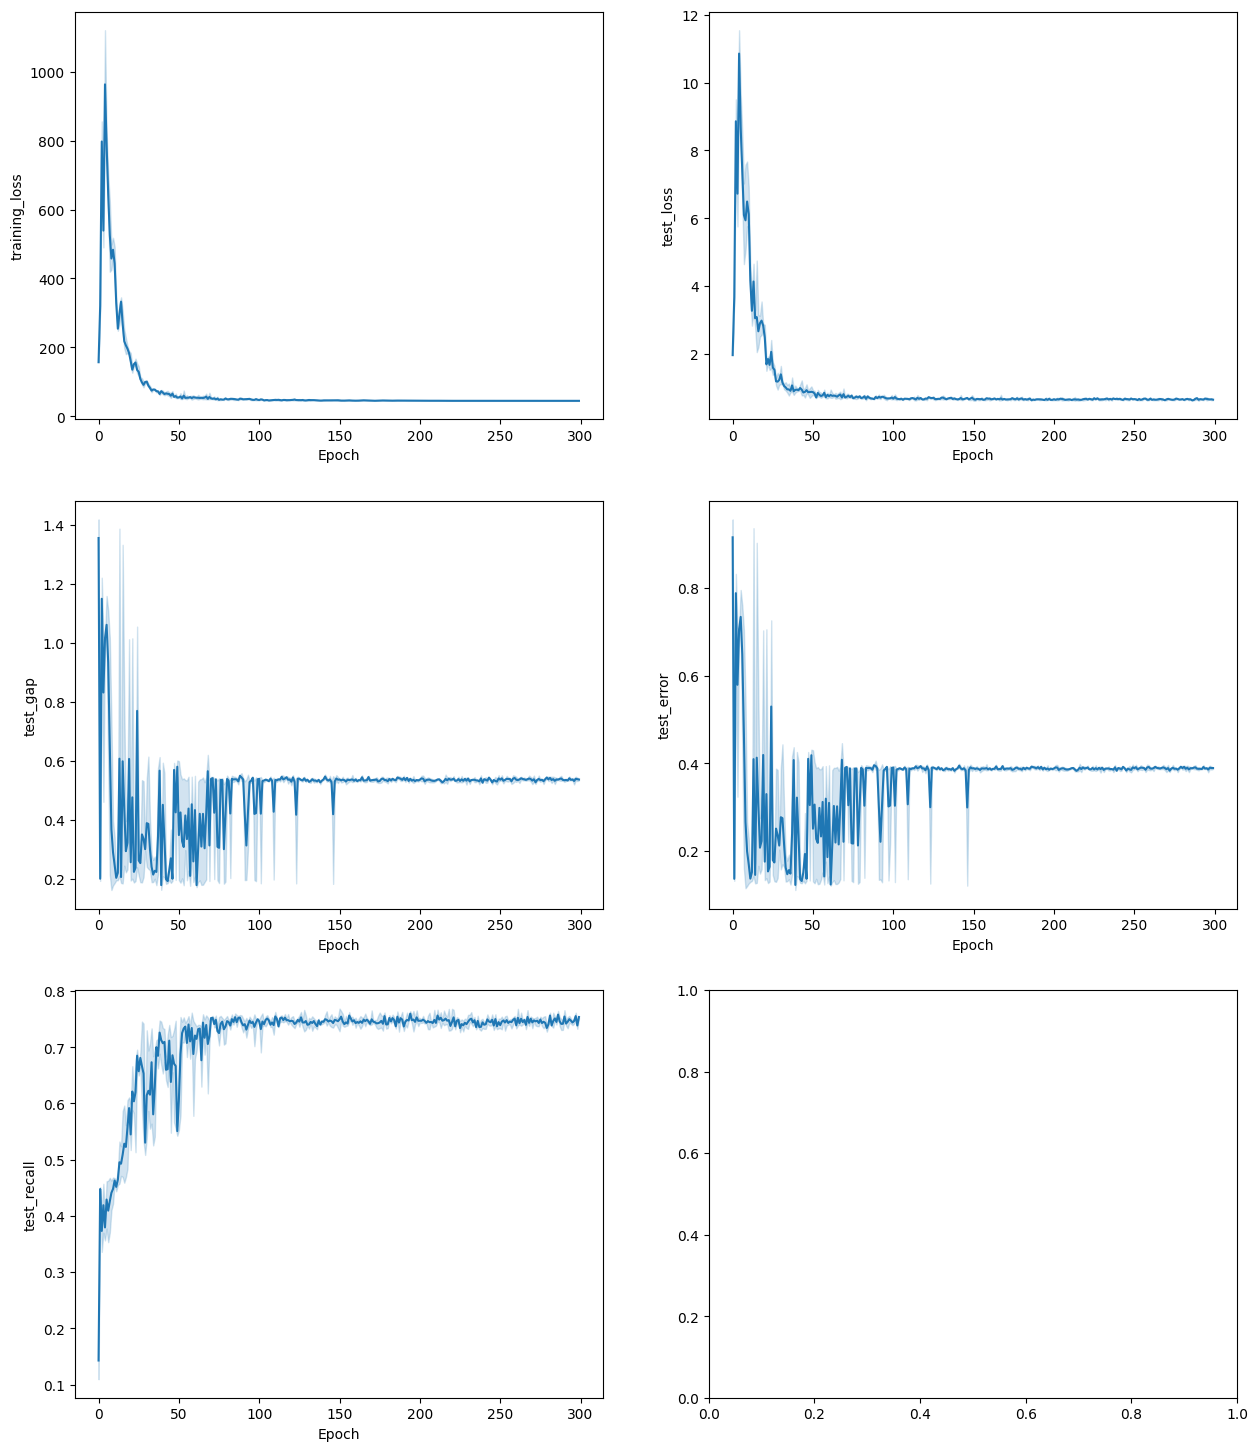

In [25]:
n_plots = len(all_results["trial_0"].keys())
n_cols = 2
n_rows = int((n_plots + n_plots%2)/2)

fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 6*n_rows))

count = 0
for key in all_results["trial_0"].keys():
    col = count %2
    row = count //2 
    count += 1

    df_long = processed[key].stack()
    df_long.index = df_long.index.to_flat_index().map(lambda x: x[0])
    sns.lineplot(df_long, errorbar='ci', ax=ax[row, col])
    ax[row, col].set_ylabel(key)
    ax[row, col].set_xlabel("Epoch")

plt.savefig(f"Results/{experiment_name}/plots.png")